## Carga y ploteo 

Se realizan las siguientes acciones:
- Carga datos de voltaje desde un archivo de texto utilizando Pandas.
- Calcula el eje de tiempo basado en un intervalo constante de 0.25 nanosegundos.
- Plotea la señal de voltaje contra el tiempo con Matplotlib.
- Configura la estética del gráfico, incluyendo tamaño de figura, título, etiquetas y leyenda.


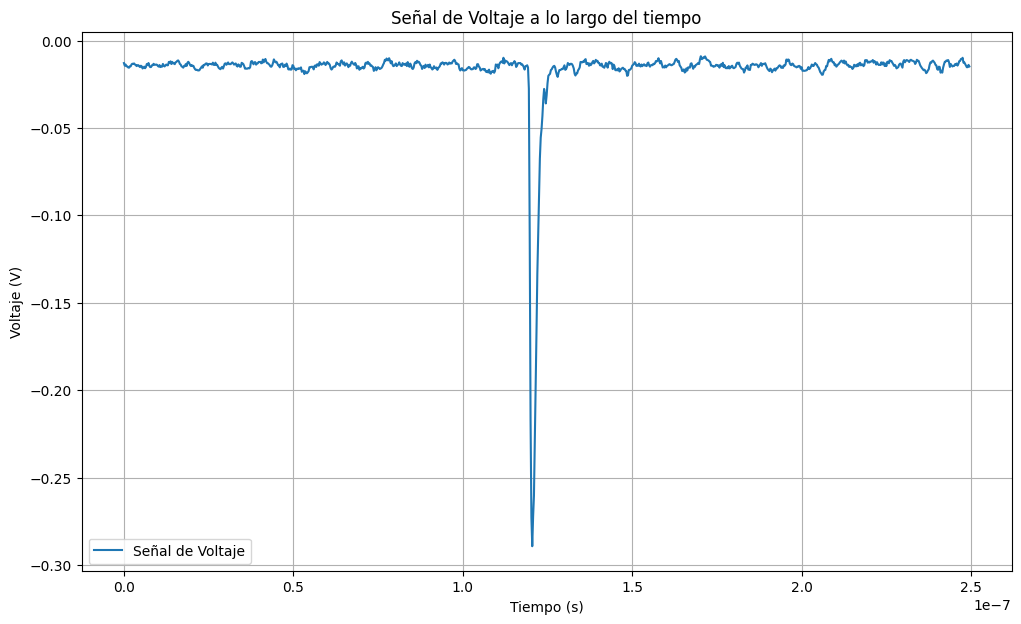

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carga los datos desde el archivo, asumiendo que están separados por espacios.
df = pd.read_csv('data1.txt', delim_whitespace=True)

# Cantidad de puntos de datos
num_puntos = df.shape[0]

# La constante temporal entre cada punto es 0.25 nanosegundos
intervalo_tiempo = 0.25e-9  # 0.25 ns convertido a segundos

# Generar el eje de tiempo. Esto crea un array que comienza en 0 y termina en (num_puntos-1) * intervalo_tiempo.
tiempo = np.arange(0, num_puntos * intervalo_tiempo, intervalo_tiempo)

# Seleccionar la primera columna de señal para plotear. Cambia '1' por cualquier otra columna para otras señales.
# La primera columna (índice 0) es probablemente un índice o tiempo, por eso se empieza desde la segunda columna.
señal = df.iloc[:, 1]

# Crear la gráfica
plt.figure(figsize=(12, 7))
plt.plot(tiempo, señal, label='Señal de Voltaje')

# Añadir títulos y etiquetas
plt.title('Señal de Voltaje a lo largo del tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje (V)')
plt.legend()

# Mostrar la gráfica
plt.grid(True)
plt.show()


Se reescalan los datos para trabajar con menos ceros

In [2]:
tiempo_ns = np.arange(0, num_puntos * intervalo_tiempo, intervalo_tiempo)*1e9

# Plot datos crudos


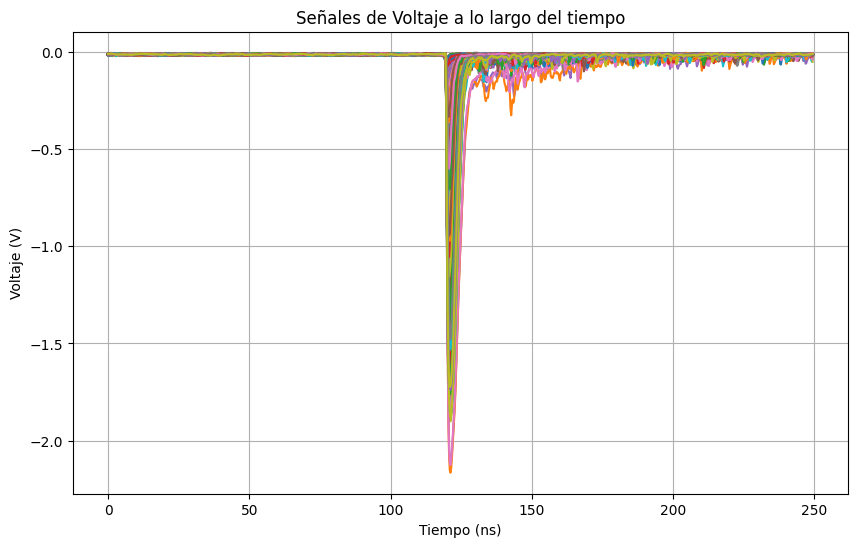

In [4]:


# Crear la figura de Matplotlib
plt.figure(figsize=(10, 6))

# Agregar trazos para cada señal
for i in range(1, min(df.shape[1], 1000)):
    plt.plot(tiempo_ns, df.iloc[:, i])

# Añadir título y etiquetas
plt.title('Señales de Voltaje a lo largo del tiempo')
plt.xlabel('Tiempo (ns)')
plt.ylabel('Voltaje (V)')


# Mostrar el gráfico
plt.grid(True)
plt.show()



## Corrección de Offset

Se calcula y corrige el offset de señales de voltaje basándose en un rango de baseline predefinido. Luego visualiza las señales ajustadas.

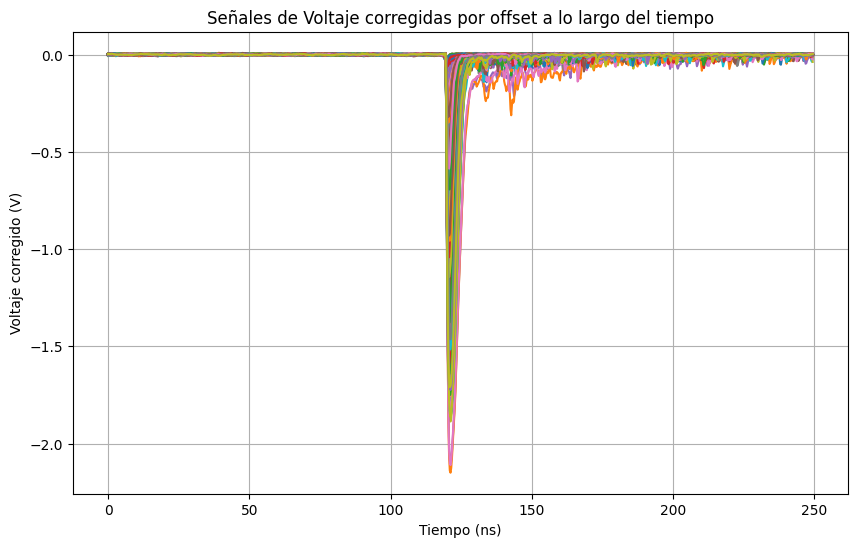

In [8]:
import matplotlib.pyplot as plt

# Definir el rango de baseline en nanosegundos
rango_inicio_baseline = 50
rango_fin_baseline = 100
indices_baseline = (tiempo_ns >= rango_inicio_baseline) & (tiempo_ns <= rango_fin_baseline)

# Corregir el offset de cada señal
df_corregido = df.copy()  # Crear una copia para almacenar los datos corregidos
for i in range(1, min(df.shape[1], 1000)):  # Asegúrate de no exceder el número de columnas en 'df'
    # Calcular el promedio del baseline
    promedio_baseline = df.iloc[indices_baseline, i].mean()
    # Restar el promedio del baseline a toda la señal
    df_corregido.iloc[:, i] = df.iloc[:, i] - promedio_baseline

# Crear la figura de Matplotlib
plt.figure(figsize=(10, 6))

# Agregar trazos para cada señal corregida
for i in range(1, min(df_corregido.shape[1], 1000)):
    plt.plot(tiempo_ns, df_corregido.iloc[:, i])

# Añadir título y etiquetas
plt.title('Señales de Voltaje corregidas por offset a lo largo del tiempo')
plt.xlabel('Tiempo (ns)')
plt.ylabel('Voltaje corregido (V)')

# Mostrar el gráfico
plt.grid(True)
plt.show()



## Filtrado de Pulsos por Amplitud

Este paso filtra los pulsos corregidos por offset, seleccionando solo aquellos que superan un umbral negativo específico dentro de un intervalo de tiempo predefinido, y visualiza los resultados.

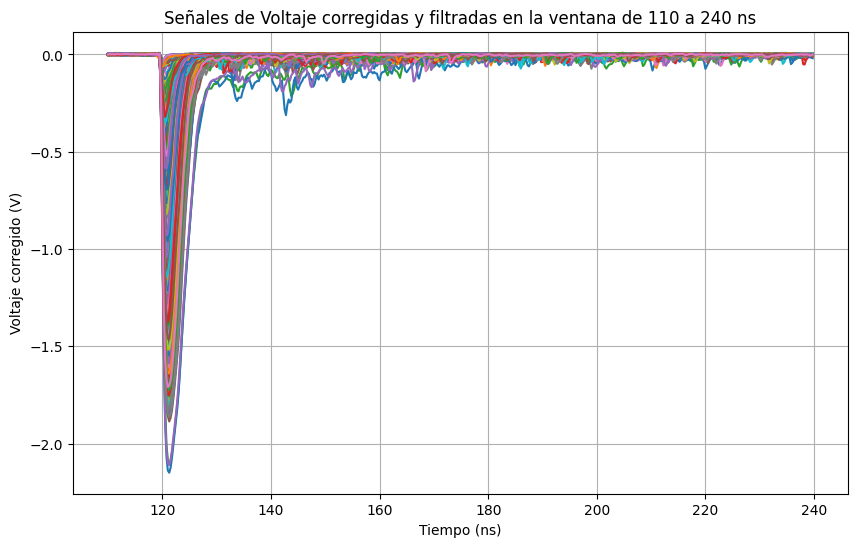

In [10]:



# Umbral para filtrar los pulsos por su amplitud negativa
umbral_negativo = -0.05

# Definir el rango de tiempo deseado, ya en nanosegundos para simplificar
rango_inicio_ns = 110 
rango_fin_ns = 240

# Filtrar los datos dentro del rango de tiempo deseado
indices_tiempo = (tiempo_ns >= rango_inicio_ns) & (tiempo_ns <= rango_fin_ns)
# Crear la figura de Matplotlib
plt.figure(figsize=(10, 6))

# Lista para almacenar los índices de las señales corregidas que cumplen con el criterio
pulsos_corregidos_cumplen_criterio = []

# Revisar cada pulso corregido para ver si cumple con el criterio de tener alguna amplitud que supere el umbral negativamente
for i in range(1, min(df_corregido.shape[1], 1000)):
    pulso_corregido_actual = df_corregido.iloc[:, i]
    # Filtrar el pulso actual basándose en el rango de tiempo deseado
    pulso_corregido_filtrado = pulso_corregido_actual[indices_tiempo]
    
    # Verificar si el pulso corregido cumple con el criterio de amplitud en el rango de tiempo filtrado
    if (pulso_corregido_filtrado < umbral_negativo).any():
        pulsos_corregidos_cumplen_criterio.append(i)  # Añadir índice del pulso corregido que cumple el criterio
        plt.plot(tiempo_ns[indices_tiempo], pulso_corregido_filtrado)

# Añadir título y etiquetas
plt.title('Señales de Voltaje corregidas y filtradas en la ventana de 110 a 240 ns')
plt.xlabel('Tiempo (ns)')
plt.ylabel('Voltaje corregido (V)')

# Mostrar el gráfico
plt.grid(True)
plt.show()


## Histograma de Amplitudes Corregidas

Se construye un histograma de las amplitudes corregidas que exceden un umbral negativo, recolectando estas amplitudes de los pulsos seleccionados y visualizando la distribución de sus valores.

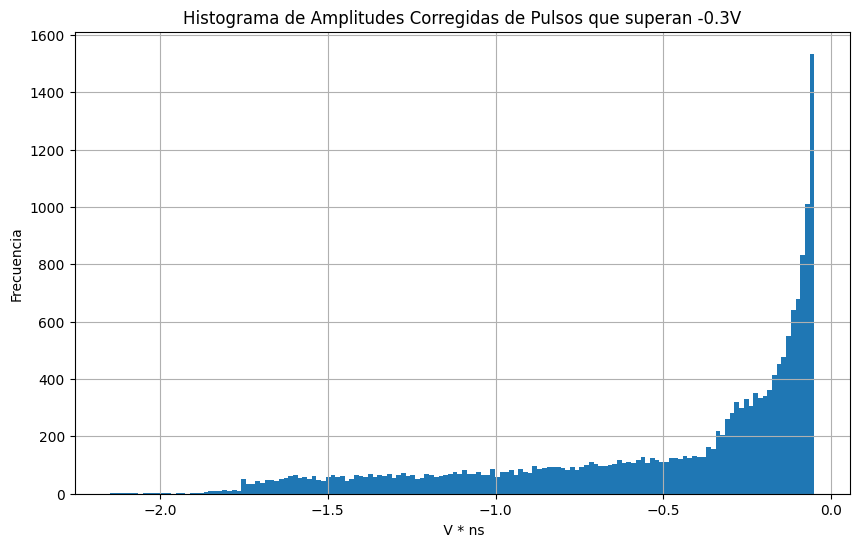

In [15]:
import matplotlib.pyplot as plt



# Umbral para identificar amplitudes negativas significativas
umbral_negativo = -0.05

# Lista para almacenar todas las amplitudes corregidas que cumplen con el criterio a través de todos los pulsos seleccionados
amplitudes_corregidas_filtradas = []

# Recorrer los índices de los pulsos corregidos que cumplen con el criterio
for i in pulsos_corregidos_cumplen_criterio:
    # Extraer el pulso corregido actual y filtrar basándose en el rango de tiempo deseado
    pulso_corregido_actual = df_corregido.iloc[indices_tiempo, i]
    
    # Añadir las amplitudes que superan negativamente el umbral a la lista de amplitudes filtradas
    amplitudes_corregidas_filtradas.extend(pulso_corregido_actual[pulso_corregido_actual < umbral_negativo].tolist())
# Crear el histograma con Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(amplitudes_corregidas_filtradas, bins=150)  # Ajusta 'bins' para cambiar el número de barras

# Añadir título y etiquetas
plt.title('Histograma de Amplitudes Corregidas de Pulsos que superan -0.3V')
plt.xlabel(' V * ns')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.grid(True)
plt.show()


Guardado de histograma en formato root

In [19]:

import uproot
# Crear un histograma con numpy
hist, bins = np.histogram(amplitudes_corregidas_filtradas, bins=150, range=(-0.3, 0))  # Ajusta los rangos y el número de bins según tus datos

# Guardar el histograma en un archivo ROOT utilizando Uproot
with uproot.recreate("histograma.root") as f:
    f["hist"] = (hist,bins)
    